In [145]:
import numpy as np
import pandas as pd
import scipy.stats as spstats
from scipy import signal
import pickle
from multiprocessing import Pool
import multiprocessing
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split

from potentials import potentialRegression
from baselines import construct_ESVM_kernel,split_dataset,set_function,standartize,standartize_train
from optimize import Run_eval_test,optimize_parallel_new
from samplers import MCMC_sampler,Generate_train
from utils import *

## Setting parameters

### Datasets:
- Pima $(N=768,\ d=8)$
- Eeg $(N=14\,980,\ d=15)$
- Susy $(N=500\,000,\ d=19)$


In [146]:
dataset = "pima" # Switch between "pima", "eeg" and "susy" 
intercept = True # Do we include the intercept
degree = 2 #order of CV's: 1 or 2 expected
typ = "probit" # logistic or probit are expected

sampler = {"sampler":"MALA","burn_type":"full","main_type":"full"} # Sampling method

# Switch between "posterior_prob_point", "posterior_prob_mean", "posterior_prob_variance", "posterior_mean"
if typ == "logistic":
    f_type = "posterior_prob_mean"
    # f_type = "posterior_mean"
elif typ == "probit":
    f_type = "posterior_prob_mean_probit"
    
step = 0.1

In [147]:
n_traj_train = 1 # Number of independent MCMC trajectories for train
n_traj_test = 100 # Number of independent MCMC trajectories for test

if (dataset == "swiss"):
    batch_size = 1*5
    test_size = 10
    N_b = 1*10**3
    N_train = 1*10**4
    N_test = 1*10**4
elif (dataset == "eeg"):    
    batch_size = 1*15
    test_size = 100
    b_n = 10 #Truncation point
    N_b = 1*10**3 # Burn-in period
    N_train = 1*10**4 # Length of the train trajectory
    N_test = 1*10**4 # Length of the test trajectories
elif (dataset == "pima"):
    batch_size = 1*15
    test_size = 50
    b_n = 20 #Truncation point
    N_b = 1*10**3 #Burn-in period
    N_train = 10**4 #Length of the train trajectory
    N_test = 10**4 #Length of the test trajectory
elif (dataset == "susy"): 
    batch_size =3*19 # Batch size for stochastic gradient
    test_size = 500
    N_b = 1*10**4 # Burn in period
    N_train = 1*10**5 # Number of samples on which we optimize
    N_test = 1*10**6 # Number of samples

## Loading data

In [148]:
if (dataset == "swiss"):
    data = pd.read_csv("./data/swiss.csv",header=None)
    outliers_inds = np.array([])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "eeg"):   
    data = pd.read_csv("./data/eeg.csv",header=None)
    outliers_inds = np.array([13179,11509,898,10386])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "pima"):
    data = pd.read_csv("./data/pima.csv",header=None)
    outliers_inds = np.array([])
    Y = data.iloc[:,-1]
    X = data.iloc[:,:-1]
elif (dataset == "susy"): 
    data = pd.read_csv("./data/susy.csv",header=None)
    outliers_inds = np.array([267630])
    Y = data.iloc[:,0]
    X = data.iloc[:,1:]

## Preprocessing data

In [149]:
# Removing the outliers
if (outliers_inds.size!=0):
    X_processed = np.delete(np.asarray(X),outliers_inds,0)
    mask = np.ones(len(Y),dtype = bool)
    mask[outliers_inds] = False
    Y_processed = Y[mask]
    Y_processed = np.asarray(Y_processed)
    X_processed = np.asarray(X_processed)
else:
    Y_processed = np.asarray(Y)
    X_processed = np.asarray(X)

In [150]:
if (f_type == "posterior_mean"):
    X_train = standartize_train(X_processed,intercept=intercept)
    Y_train = Y_processed
else:
    X_train,X_test,Y_train,Y_test = train_test_split(X_processed,Y_processed,test_size=test_size,random_state=1812,stratify=Y_processed)
    X_train,X_test = standartize(X_train,X_test,intercept=intercept)

## Creating potential

In [151]:
# Creating potential
Cur_pot = potentialRegression(Y_train, X_train, typ, print_info = True)
d = Cur_pot.d 

## Sampling training trajectories

In [152]:
if sampler["sampler"] == "ULA":
    res = Generate_train(n_traj_train, sampler, Cur_pot, step, N_b, N_train, d)
    res = np.asarray(res)
    traj,traj_grad = res[:,0,:,:],res[:,1,:,:]
else:
    res = Generate_train(n_traj_train, sampler, Cur_pot, step, N_b, N_train, d)
    traj = []
    traj_grad = []
    for i in range(len(res)):
        traj.append(res[i][0])
        traj_grad.append(res[i][1])
        print("accepted = ",res[i][2])
    traj = np.asarray(traj)
    traj_grad = np.asarray(traj_grad)

ncores =  12


accepted =  9923


In [153]:
print(traj.shape)

(1, 10000, 9)


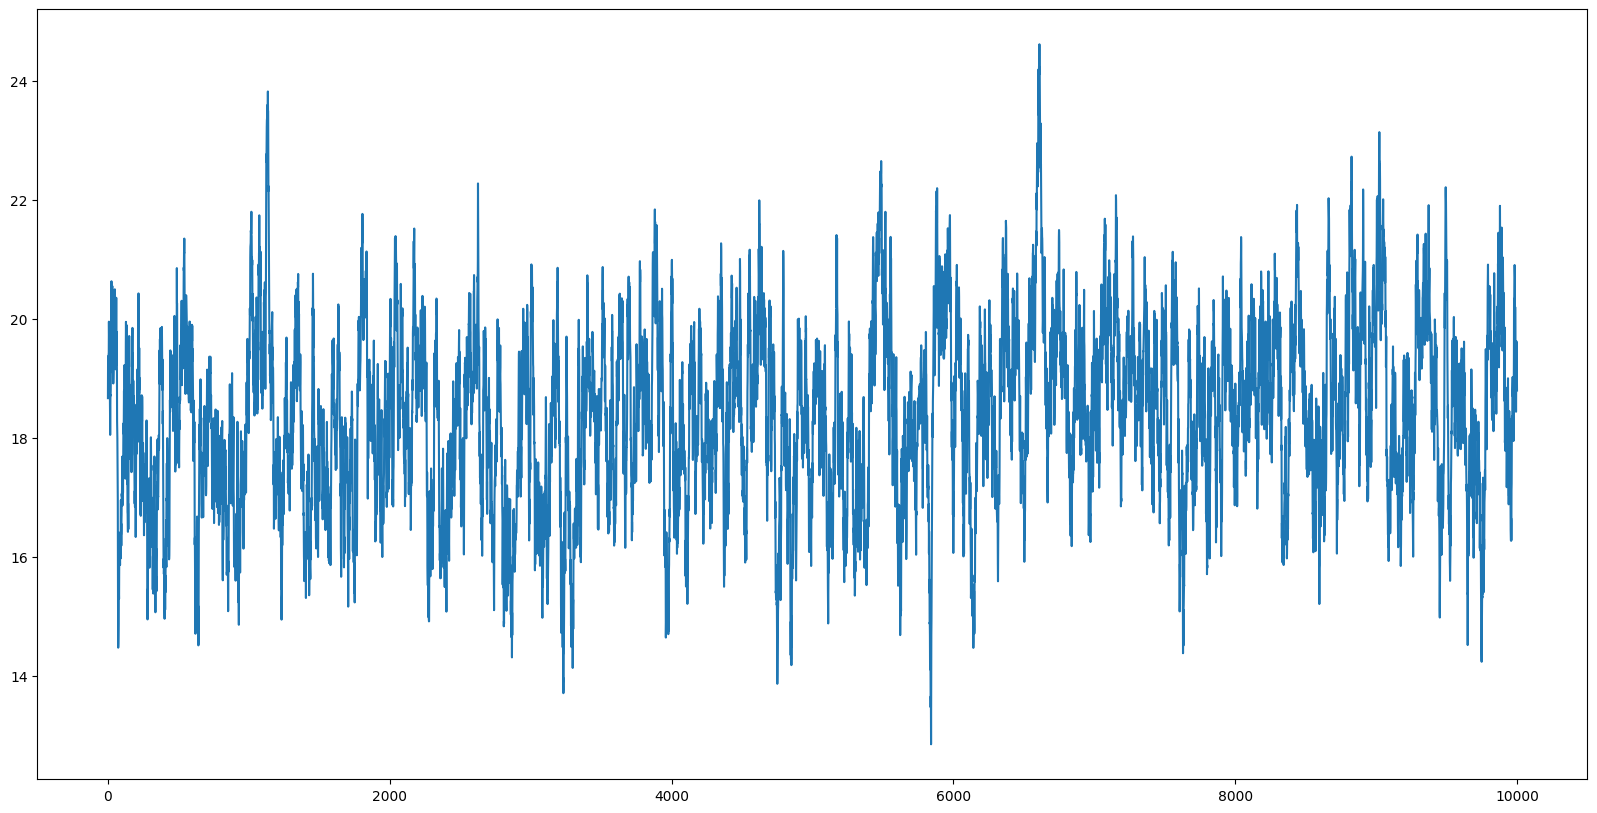

In [154]:
plt.figure(figsize = (20,10))
plt.plot(traj[0,:,2])

## Initialization of function values

If the function you are willing to evaluate is "posterior_prob_point" or "posterior mean" — pass through inds_arr parameter indices of variables, over which you are willing to optimize. For example, in case of "posterior_prob_point",

>inds_arr = np.array([0])

means that you are willing to reduce variance for a point from the test dataset with index $0$.

In [155]:
if (f_type == "posterior_mean"):
    inds_arr = np.array([1]) # Taking the second index (not intercept)
    params = None
else:
    params = {"X":X_test,"Y":Y_test}
    inds_arr = np.array([0])
    
f_vals = set_function(f_type,traj,inds_arr,params)

## Training coefficients for EVM and ESVM

In [156]:
# Construct kernel
W_train_spec = construct_ESVM_kernel(N_train,b_n)
W_test_spec = construct_ESVM_kernel(N_test,b_n)

opt_structure_train = {
    "W":W_train_spec,
    "n_restarts": 5, # Number of restarts during optimization,
    "sigma": 1.0, # Deviation of starting points
    "tol": 1e-5, # Tolerance (for the norm of gradient)
    "alpha": 0.0, # Ridge penalty for 2nd order control functionals
    "beta": 10000.0 # smoothing parameter in the softmax
}
methods = ["ESVM","EVM"]

In [157]:
coef_dict = optimize_parallel_new(degree,inds_arr,f_vals,traj,traj_grad,opt_structure_train,methods)

## Coefficients for control variates

In [158]:
print("Coefficients for ESVM")
print(coef_dict["ESVM"])
print("Coefficients for EVM")
print(coef_dict["EVM"])

Coefficients for ESVM
[[-6.84845738e-03  1.86450736e-03  1.27638770e-02  1.80426772e-04
   1.78853468e-03  1.81759029e-03  6.19318000e-03  6.94093293e-03
   7.60864577e-03 -3.45914024e-05  6.85319797e-06  2.69925663e-06
  -1.09333757e-05  2.17758786e-05  1.11481352e-06  3.11348480e-05
   1.49255546e-05 -3.35768949e-06  6.85316874e-06 -3.23225436e-05
  -2.85029277e-05  4.12584000e-06  2.25282244e-06 -5.67864083e-06
   1.71325018e-05 -3.64343740e-05  9.22358519e-06  2.69925269e-06
  -2.85029302e-05 -6.12940201e-05 -8.64515747e-06 -2.33213882e-06
  -7.03975890e-06 -2.48879486e-05 -2.99600365e-05 -2.23542404e-05
  -1.09334321e-05  4.12580896e-06 -8.64514743e-06 -2.11788678e-05
   1.08625042e-05  4.08562202e-06 -3.11457311e-05  1.53232470e-05
  -2.95359020e-05  2.17759205e-05  2.25282559e-06 -2.33213209e-06
   1.08625129e-05 -2.74137340e-05 -2.34749910e-06 -2.50292288e-05
   2.35933454e-05 -2.78901310e-06  1.11477717e-06 -5.67873647e-06
  -7.03977385e-06  4.08567205e-06 -2.34754390e-06 -3.3

## Testing EVM and ESVM

In [159]:
test_params = {
    "W":W_test_spec,
    "step":step,
    "burn_in":N_b,
    "n_test":N_test,
    "dim":d
}
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(Run_eval_test, [(i,degree,sampler,methods,inds_arr,Cur_pot,test_params,coef_dict,params,f_type) for i in range (n_traj_test)])
trav.close()

In [160]:
methods_enh = ['Vanilla'] + methods
print(methods_enh)
ints_result = {key: [] for key in methods_enh}
vars_result = {key: [] for key in methods_enh}

['Vanilla', 'ESVM', 'EVM']


In [161]:
for i in range(len(res)):
    for j in range(len(methods_enh)):
        ints_result[methods_enh[j]].append(res[i][0][methods_enh[j]][0])
        vars_result[methods_enh[j]].append(res[i][1][methods_enh[j]][0])
for key in methods_enh:
    ints_result[key] = np.asarray(ints_result[key])
    vars_result[key] = np.asarray(vars_result[key])

## Results

In [162]:
print("Estimators")
for i in range(len(methods_enh)):
    print(methods_enh[i])
    print("mean: ",np.mean(ints_result[methods_enh[i]],axis=0))
    print("std: ",np.std(ints_result[methods_enh[i]],axis=0))

Estimators
Vanilla
mean:  [0.72365071]
std:  [0.00061444]
ESVM
mean:  [0.72369442]
std:  [2.54863468e-06]
EVM
mean:  [0.72369378]
std:  [4.33947096e-06]


In [163]:
print("Variances")
for i in range(len(methods_enh)):
    print(methods_enh[i])
    print(np.mean(vars_result[methods_enh[i]],axis=0))

Variances
Vanilla
[0.00214205]
ESVM
[6.52960892e-08]
EVM
[2.14876171e-07]


In [164]:
print(f"{dataset}-d{degree}-{typ}-{sampler['sampler']}")
print("Variance reduction factors")
for i in ["ESVM","EVM"]:
    print(i)
    print(np.mean(vars_result['Vanilla']/vars_result[i]))

pima-d2-probit-MALA
Variance reduction factors
ESVM
34930.356093606555
EVM
10315.520849811373


## Plotting results

In [196]:
ints_result_array = np.load("Results/log/probit/pima-d2-probit-RWM.npy", allow_pickle=True)
ints_result = ints_result_array.item()

In [197]:
method = 'MALA' # sampler["sampler"]
title = ""
labels = [f'Vanilla\n{method}', f'{method}\nwith EVM',f'{method}\nwith ESVM']

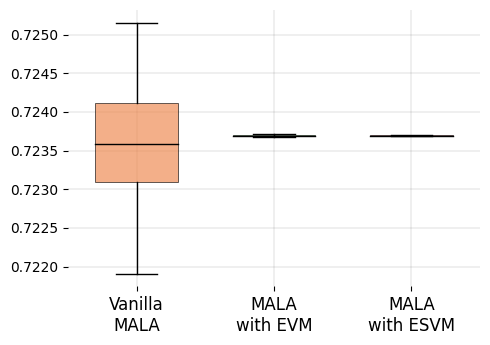

In [198]:
# Box plot
data = [ints_result['Vanilla'][:,0],ints_result['EVM'][:,0],ints_result['ESVM'][:,0]] 
boxplot_ind(data, title, labels)

In [199]:
# method = "MALA"
labels = [f'{method}\nwith EVM',f'{method}\nwith ESVM']

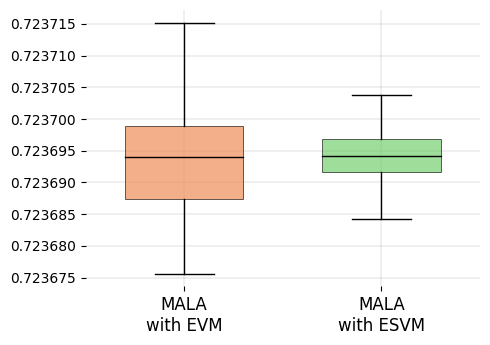

In [200]:
# Box plot
data = [ints_result['EVM'][:,0],ints_result['ESVM'][:,0]] 
boxplot_ind(data, title, labels)
# plt.savefig(f"pic/test/boxplot_{dataset}_d{degree}_{typ}_{sampler['sampler']}.png")